# Import necessary libraries

In [1]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import copy
import lightgbm as lgb
import os
import sys
from ivmodels import AnchorRegression

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data set

In [4]:
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"
HIRID_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_dynamic.parquet"
HIRID_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_static.parquet"
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"
MIIV_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_static.parquet"
MIIV_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_dynamic.parquet"

## Preprocessing

In [5]:
def preprocess(DYNAMIC_PATH, STATIC_PATH, impute=True):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'patientid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time',
        'datetime': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    if impute==True:
            
        # Detect -inf values in DataFrame day1
        inf_mask = df_day1.isin([-np.inf])
        # Add an indicator column based on whether -inf was replaced
        df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)

        # Create a new DataFrame to hold the indicators
        indicators = df.isna().astype(int)

        # Rename the indicator columns to distinguish them
        indicators.columns = [str(col) + '_was_nan' for col in df.columns]

        # Replace NaN values with the mean of the column
        for column in df.columns:
            df[column].fillna(df[column].mean(), inplace=True)

        # Concatenate the original DataFrame with the indicator DataFrame
        df = pd.concat([df, indicators], axis=1)
    
    else:
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)
    
    X = df.drop('hr3', axis=1)
    y = df['hr3']
    return X,y

In [6]:
X_eicu, y_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)

In [7]:
X_hirid, y_hirid = df_hirid = preprocess(HIRID_DATA_PATH_DYNAMIC, HIRID_DATA_PATH_STATIC)

In [8]:
X_mimic, y_mimic = df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)

In [9]:
X_miiv, y_miiv = df_miiv = preprocess(MIIV_DATA_PATH_DYNAMIC, MIIV_DATA_PATH_STATIC)

In [15]:
X_eicu

,alb,alp,alt,ast,be,bicar,bili,bili_dir,bnd,bun,...,sbp_was_nan,temp_was_nan,tnt_was_nan,urine_was_nan,wbc_was_nan,age_was_nan,sex_was_nan,height_was_nan,weight_was_nan,inf_replaced_was_nan
stay_id,,,,,,,,,,,,,,,,,,,,,
141194,2.300000,4.077537,2.995732,3.178054,-0.525633,16.666667,-0.916291,-0.893460,1.987946,3.423057,...,0,1,1,1,0,0,0,0,0,0
141233,2.795416,4.425441,3.550862,3.829360,-0.525633,24.141384,-0.266517,-0.893460,1.987946,3.100372,...,0,1,1,1,0,0,0,0,0,0
141244,2.795416,4.425441,3.550862,3.829360,-0.525633,27.000000,-0.266517,-0.893460,1.987946,2.079442,...,0,1,1,1,0,0,0,0,0,0
141265,2.795416,4.425441,3.550862,3.829360,-0.525633,27.000000,-0.266517,-0.893460,1.987946,2.564949,...,1,1,1,0,0,0,0,0,0,0
141304,2.795416,4.425441,3.550862,3.829360,0.000000,29.000000,-0.266517,-0.893460,1.987946,3.871201,...,1,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353201,2.795416,4.425441,3.550862,3.829360,22.000000,38.000000,-0.266517,-0.893460,1.987946,4.430817,...,1,1,1,0,0,0,0,0,0,0
3353213,2.795416,4.425441,3.550862,3.829360,-8.000000,21.000000,-0.266517,-0.893460,1.987946,2.397895,...,1,1,1,0,0,0,0,0,0,0
3353216,2.800000,3.951244,2.197225,2.995732,-6.750000,20.000000,-1.609438,-0.893460,1.987946,2.012676,...,0,1,1,0,0,0,0,0,0,0


## Automated EDA

In [ ]:
dataframes = {
    'eicu': df_eicu,
    'hirid': df_hirid,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

# Predictions

## Training - What is the difference between continuous learning and refit?

In [181]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [220]:
X_train = df_eicu.drop('hr3', axis=1)
y_train = df_eicu['hr3']

ols = LR()
ols.fit(X_train,y_train)

# generate a feature name
feature_name = [col for col in X_train.columns]

# specify configurations as a dict
params_lgbm = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
params_rf = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
lgb_train = lgb.Dataset(data=X_train, label=y_train,free_raw_data=False)
lgbm = lgb.train(params_lgbm,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10
                )
rf = lgb.train(params_rf,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10,
                )
lgbm.save_model('lgbm_trained_model.txt')
rf.save_model('rf_trained_model.txt')

print("Training MSE LGBM:", mean_squared_error(y_train, lgbm.predict(X_train)))
print("Training MSE RF:", mean_squared_error(y_train, rf.predict(X_train)))
print("Training MSE OLS:", mean_squared_error(y_train, ols.predict(X_train)))

X_test_hirid, X_test_mimic, X_test_miiv = df_hirid.drop('hr3', axis=1), df_mimic.drop('hr3', axis=1), df_miiv.drop('hr3', axis=1)
y_test_hirid, y_test_mimic, y_test_miiv = df_hirid['hr3'], df_mimic['hr3'], df_miiv['hr3']
# Do nothing prediction
dummy_mse_hirid = mean_squared_error(y_test_hirid, np.full_like(y_test_hirid, y_train.mean()))
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
dummy_mse_miiv = mean_squared_error(y_test_miiv, np.full_like(y_test_miiv, y_train.mean()))
print(f'Do nothing-mse on Hirid is {dummy_mse_hirid}, on Mimic is {dummy_mse_mimic}, on Miiv is {dummy_mse_miiv}')

# Hypothesis: Higher MSE on Mimic is caused by children
X_test_mimic = df_mimic[df_mimic["age"]>18].drop('hr3', axis=1)
y_test_mimic = df_mimic[df_mimic["age"]>18]['hr3']
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
print(f'Do nothing-mse on Mimic (without children) is {dummy_mse_mimic}')


Training MSE LGBM: 166.32518032864854
Training MSE RF: 152.31950765638805
Training MSE OLS: 148.35704250894904
Do nothing-mse on Hirid is 278.0011333281888, on Mimic is 548.8081578499456, on Miiv is 243.3661983075155
Do nothing-mse on Mimic (without children) is 226.98293268716793


In [ ]:
""""""""""
Do only if access to Euler otherwise pc goes in brrrr state
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)
#best_training_model = grid_search.best_estimator_
#print("Finished grid search and selected best estimator \n")
"""""""""""

In [207]:
test_dataframes = {
    'hirid': df_hirid,
    'mimic': df_mimic,
    'miiv': df_miiv
    }
mse_values = {name: {'lgbm': [], 'rf': [], 'ols': []} for name in test_dataframes}
n_fine_tune_range = [25, 50, 100, 200, 400, 800, 1600]
for name, df in test_dataframes.items():
    X_test = df.drop('hr3', axis=1)
    y_test = df['hr3']

    mse_values[name]['lgbm'].append(mean_squared_error(y_test,lgbm.predict(X_test,num_iteration=lgbm.best_iteration))) # Base line prediction - without fine tuning
    mse_values[name]['rf'].append(mean_squared_error(y_test,rf.predict(X_test,num_iteration=rf.best_iteration))) # Base line prediction - without fine tuning
    mse_values[name]['ols'].append(mean_squared_error(y_test,ols.predict(X_test)))
    
    for n_fine_tune in n_fine_tune_range:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test, y_test, train_size=n_fine_tune, random_state=42)
        #print(X_fine_tune.shape, X_evaluate.shape)

        lgbm = lgb.Booster(model_file='lgbm_trained_model.txt')
        refit_lgbm = lgbm.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['lgbm'].append(mean_squared_error(y_evaluate, refit_lgbm.predict(X_evaluate,num_iteration=lgbm.best_iteration)))

        rf = lgb.Booster(model_file='rf_trained_model.txt')
        refit_rf = rf.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['rf'].append(mean_squared_error(y_evaluate, refit_rf.predict(X_evaluate,num_iteration=rf.best_iteration)))
        
        mse_values[name]['ols'].append(mean_squared_error(y_evaluate, ols.predict(X_evaluate)))

<Axes: >

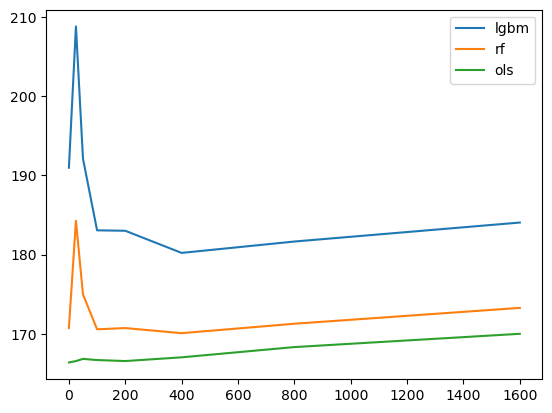

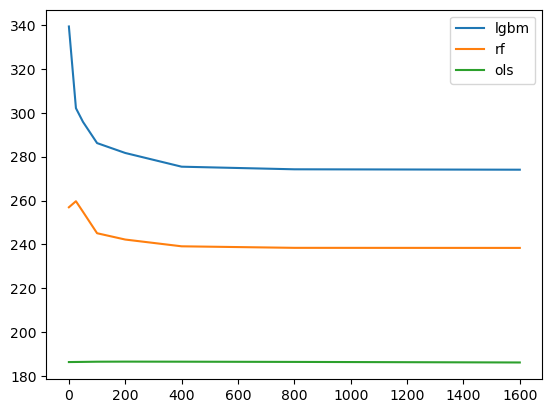

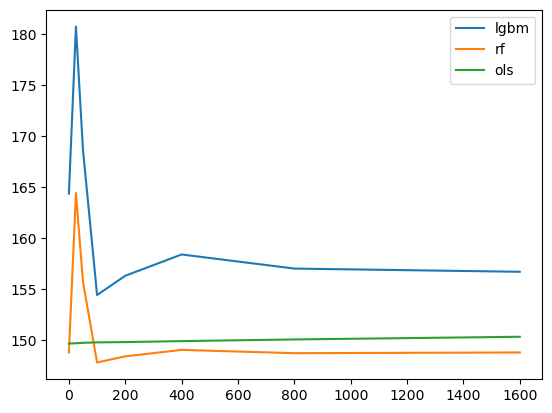

In [221]:
mse_hirid_df = pd.DataFrame(mse_values['hirid'])
mse_hirid_df.title='EICU on HIRID'
mse_hirid_df.index = [0, 25, 50, 100, 200, 400, 800, 1600]
mse_mimic_df = pd.DataFrame(mse_values['mimic'])
mse_mimic_df.title='EICU on MIMIC'
mse_mimic_df.index = [0, 25, 50, 100, 200, 400, 800, 1600]
mse_miiv_df = pd.DataFrame(mse_values['miiv'])
mse_miiv_df.title='EICU on MIIV'
mse_miiv_df.index = [0, 25, 50, 100, 200, 400, 800, 1600]
mse_hirid_df.plot()
mse_mimic_df.plot()
mse_miiv_df.plot()

In [218]:
mse_hirid_df["ols"]

0       166.386174
25      166.561511
50      166.839867
100     166.693752
200     166.566098
400     167.035664
800     168.330407
1600    170.006601
Name: ols, dtype: float64

### Anchor Regression + Residual RF  --> location als anchor

In [210]:
gamma=2
# Centering
X_centered = X_train.drop(columns=['age', 'height', 'sex', 'weight']) - X_train.drop(columns=['age', 'height', 'sex', 'weight']).mean()
Y_centered = y_train - y_train.mean()

# Convert A to a NumPy array if it's a DataFrame for matrix operations
A_matrix = X_train[['age', 'sex', 'weight', 'height']].values   
# Fit a linear regression model for each independent variable in X_centered using A_matrix
residuals_X = []
fitted_values_X = []
residuals_y = []
fitted_values_y = []
for column in X_centered.columns:
    model = LR()
    model.fit(A_matrix, X_centered[column])
    residuals_X.append(X_centered[column] - model.predict(A_matrix))
    fitted_values_X.append(model.predict(A_matrix))

model = LR()
model.fit(A_matrix, Y_centered)
residuals_y.append(Y_centered - model.predict(A_matrix))
fitted_values_y.append(model.predict(A_matrix))

# Convert lists of residuals and fitted values to NumPy arrays
residuals_X_matrix = np.column_stack(residuals_X)
fitted_values_X_matrix = np.column_stack(fitted_values_X)
residuals_y = np.column_stack(residuals_y)
fitted_values_y = np.column_stack(fitted_values_y)

# Compute anchor_data by adding residuals to the scaled fitted values
anchor_data = residuals_X_matrix + np.sqrt(gamma) * fitted_values_X_matrix
anchor_data_target = residuals_y + np.sqrt(gamma) * fitted_values_y

anchor_reg = LR()
anchor_reg.fit(anchor_data, anchor_data_target)
pred_anchor = anchor_reg.predict(anchor_data)

res_anchor = anchor_data_target - pred_anchor
lgb_train = lgb.Dataset(data=X_centered, label=res_anchor,free_raw_data=False)
anchor_rf = lgb.train(params_rf,
                lgb_train,
                valid_sets=lgb_train,
                num_boost_round=10,
                )
pred_rf = anchor_rf.predict(X_centered).reshape(-1,1)
pred_anchor_rf = pred_anchor + pred_rf
print(mean_squared_error(Y_centered.values.reshape(-1, 1),pred_anchor_rf))

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


146.62963590871328


# Streamlining

In [ ]:
from icu_experiments.load_data import load_data_for_prediction
from icu_experiments.preprocessing import make_feature_preprocessing, make_anchor_preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from lightgbm import LGBMRegressor, Booster
from sklearn.linear_model import LinearRegression
import itertools
from ivmodels import AnchorRegression
from sklearn.metrics import mean_squared_error

outcome = "hr"

Xy = load_data_for_prediction(["eicu"], outcome=outcome, log_transform=True)
Xy_train = Xy['eicu']['train']
Xy_test = Xy['eicu']['test']

Xy_new = load_data_for_prediction(['hirid'], outcome=outcome, log_transform=True)
Xy_test_new = Xy_new['hirid']['train']
Xy_tuning_data = Xy_new['hirid']['test']

preprocessing_steps = make_feature_preprocessing(missing_indicator=True)
preprocessor = ColumnTransformer(transformers=preprocessing_steps).set_output(transform="pandas") # Allow to preprocess subbsets of data differently

anchor_columns = ['hospital_id']
anchor_preprocessing_steps = make_anchor_preprocessing(anchor_columns)
anchor_preprocessor = ColumnTransformer(
        anchor_preprocessing_steps + preprocessing_steps
        #preprocessing_steps
    ).set_output(transform="pandas")

p1 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor())
])
p2 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor())
])
p3 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])
p4 = Pipeline(steps=[
    ('preprocessing', anchor_preprocessor),
    ('model', AnchorRegression())
])

param_grid_lgbm = {
    'model__boosting_type': ['gbdt'],  # Set the boosting type for LightGBM
    'model__num_leaves': [15, 31],
    'model__subsample': [0.8, 1.0],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'model__n_estimators': [50, 100, 800]
}
param_grid_rf = {
    'model__boosting_type': ['rf'],  # Set the boosting type for LightGBM
    'model__num_leaves': [15, 31],
    'model__subsample': [0.8, 1.0],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'model__n_estimators': [50, 100, 800]
}
param_grid_anchor = {
    'instrument_regex': ["anchor"],
    'gamma': [1, 3.16, 10, 31.6, 100, 316, 1000, 3162, 10000],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

### Compare Performance from Training to Target Data - Parameters chosen via GridCV on Training Data

In [ ]:
search = GridSearchCV(p1, param_grid_lgbm)
search.fit(Xy_train, Xy_train['outcome'])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
grid_search_params_lgbm = search.best_params_
print(search.best_params_)

search = GridSearchCV(p2, param_grid_rf)
search.fit(Xy_train, Xy_train['outcome'])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
grid_search_params_rf = search.best_params_
print(search.best_params_)

p1.set_params(**grid_search_params_lgbm)
p1.fit(Xy_train, Xy_train['outcome'])
p2.set_params(**grid_search_params_rf)
p2.fit(Xy_train, Xy_train['outcome'])

mse_grid_lgbm = mean_squared_error(Xy_test_new['outcome'], p1.predict(Xy_test_new))
mse_grid_rf = mean_squared_error(Xy_test_new['outcome'], p2.predict(Xy_test_new))

### Compare Performance from Training to Target Data - Parameters chosen via Evaluation on Target Data

- Train Data with different parameters on Training set
- Evaluate Train Data on fine tuning data from target set 
- choose the best performing parameters
- do this for all possible n from the fine tuning data set

In [ ]:
def find_best_parameters(Xy_train, Xy_tuning_data, p, param_grid):
    # Initialize a list to store the best parameters and MSE for each n
    results_for_n = []

    for n in [25, 50, 100, 200, 400, 800, 1600]:
        # Initialize variables to keep track of the best parameters and MSE for the current n
        best_params = None
        best_mse = float('inf')  # Initialize with a large value

        # Iterate over all possible combinations of hyperparameters
        for param_set in itertools.product(*param_grid.values()):
            param_dict = dict(zip(param_grid.keys(), param_set))

            # Create and train the LightGBM model
            params = {
                **param_dict  # Include other relevant parameters
            }
            p.set_params(**{'model__' + key: value for key, value in params.items()})
            p.fit(Xy_train, Xy_train['outcome'])

            # Make predictions on the subset of data
            y_pred = p.predict(Xy_tuning_data.head(n))

            # Calculate mean squared error for this parameter set
            mse = mean_squared_error(Xy_tuning_data['outcome'].head(n), y_pred)

            # Check if this MSE is better than the current best for the current n
            if mse < best_mse:
                best_mse = mse
                best_params = param_dict

        # Store the best parameters and MSE for the current n in the list
        results_for_n.append({'n': n, 'best_params': best_params, 'best_mse': best_mse})

    return results_for_n

#results_p1 = find_best_parameters(Xy_train, Xy_tuning_data, p1, param_grid_lgbm)
#results_p2 = find_best_parameters(Xy_train, Xy_tuning_data, p2, param_grid_rf)
results_p4 = find_best_parameters(Xy_train, Xy_tuning_data, p4, param_grid_anchor)

def calculate_mse(X_train, y_train, X_test, y_test, p, results, boosting_type=None, is_anchor=False):
    mse_for_n = []
    i = 0
    for n in [25, 50, 100, 200, 400, 800, 1600]:
        params = {f'model__{key}': value for key, value in results[i]['best_params'].items()}
        if not is_anchor: 
            params['model__boosting_type'] = boosting_type
        p.set_params(**params)
        p.fit(X_train, y_train)
        y_pred = p.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_for_n.append({'n': n, 'mse': mse})
        i += 1
    return mse_for_n

mse_eicu_to_hirid_p1 = calculate_mse(Xy_train, Xy_train['outcome'], Xy_test_new, Xy_test_new['outcome'], p1, results_p1, 'gbdt')
mse_eicu_to_hirid_p2 = calculate_mse(Xy_train, Xy_train['outcome'], Xy_test_new, Xy_test_new['outcome'], p2, results_p2, 'rf')
mse_eicu_to_hirid_p4 = calculate_mse(Xy_train, Xy_train['outcome'], Xy_test_new, Xy_test_new['outcome'], p4, results_p4, is_anchor=True)

# OLS MSE Calculation
p3.fit(Xy_train, Xy_train['outcome'])
mse_eicu_to_hirid_p3 = mean_squared_error(Xy_test_new['outcome'], p3.predict(Xy_test_new, Xy_test_new['outcome']))
mse_eicu_to_hirid_dummy_prediction = mean_squared_error(Xy_test_new['outcome'], np.full_like(Xy_test_new['outcome'],Xy_train[outcome].mean()))

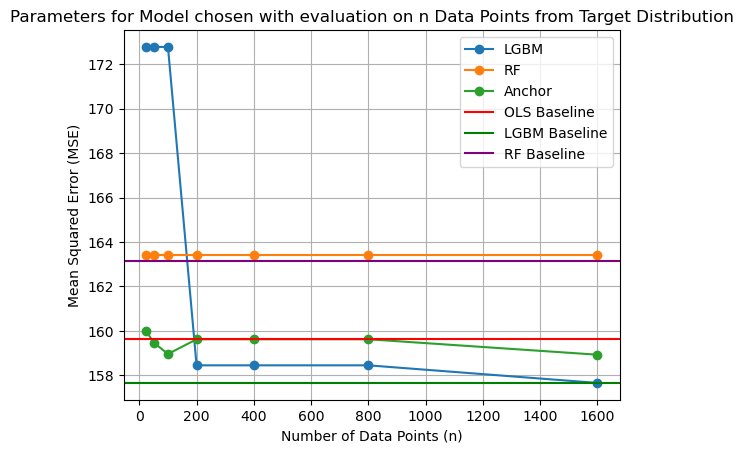

In [47]:
n = [25, 50, 100, 200, 400, 800, 1600]
plt.plot(n, ([item['mse'] for item in mse_eicu_to_hirid_p1]), marker='o', linestyle='-', label = 'LGBM')
plt.plot(n, [item['mse'] for item in mse_eicu_to_hirid_p2], marker='o', linestyle='-', label = 'RF')
plt.plot(n, [item['mse'] for item in mse_eicu_to_hirid_p4], marker='o', linestyle='-', label = 'Anchor')
plt.axhline(y=mse_eicu_to_hirid_p3, color='red', linestyle='-', label='OLS Baseline')
plt.axhline(y=mse_grid_lgbm, color='green', linestyle='-', label='LGBM Baseline')
plt.axhline(y=mse_grid_rf, color='purple', linestyle='-', label='RF Baseline')
#plt.axhline(y = mean_squared_error(Xy_test_new['outcome'], np.full_like(Xy_test_new['outcome'],Xy_train[outcome].mean())), color = 'black', label='Train Average')
plt.title('Parameters for Model chosen with evaluation on n Data Points from Target Distribution')
plt.xlabel('Number of Data Points (n)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

The hyperparameters were chosen such that they minimize the the mse on the fine-tuning data set of the target distribution. We have n = 25, 50, 100, 200, 400, 800 and 1600 datapoints from the target distribution. In an inital step, we chose randomly 1600 data points from the target data and called it Xy_tuning_data - they are not part of the final evaulation data (i.e. the plotted mse after training). The hyperparameters were chosen from: 

param_grid_lgbm = { \
    'boosting_type': ['gbdt'], \
    'num_leaves': [15, 31], \
    'subsample': [0.8, 1.0], \ 
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Increase the range of learning rates \
    'n_estimators': [50, 100, 800]  # Increase the range of estimators\
} \

param_grid_rf = {\
    'boosting_type': ['rf'],\
    'num_leaves': [15, 31],\
    'subsample': [0.8, 1.0],\
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Increase the range of learning rates\
    'n_estimators': [50, 100, 800]  # Increase the range of estimators\
}\

param_grid_anchor = {\
    'instrument_regex': ["anchor"],\
    'gamma': [1, 3.16, 10, 31.6, 100, 316, 1000, 3162, 10000],\
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]\
}


The parameters for evaluation were chosen as follows:
1. For each combination of the parameters train the model on the training data
2. Calculate the mse on the fine-tuning data from the trainings distribution 
3. For each n, choose the parameter combination such that it minimizes the mse on the fine-tuning data

The LGBM-pipeline is called p1, the RF-pipeline is called p2, the OLS-pipeline is called p3, the Anchor-pipeline is called p4.

For OLS we proceed different. Here we simply train the model on the trainings data and evaluate it on the target data. 

In a successive step, we perform the same parameter selection process but on the trainings data and calculate the mse on the target data. The performance is denoted in the plot by the model + Baseline. Surprisingly, none of the models was able to beat the Baselines. Only LGBM was able for n = 1600 to accomplish identical precision as its baseline. It seems like LGBM can already identify the same important hyperparameters when only having access to 1600 tuning data points. Already after just having 50 data points available, anchor is able to beat OLS. The predictive performance of the RF seems to be independent of the choosen parameters. The choosen parameters seem to have high influence on the predictive performance of LGBM. After only having 200 data points available, LGBM is able to reduce its mse by 8%. 

This may be caused by the lack of available hyperparameters. It would be interisting to see if the models are able to beat its baseline when allow more possibilities. A possible follow up question is if the predictive perfromance improves when n=2000 (Hypothesis: Yes, since the prediction has more accurate data)

All models were able to beat the average-prediction of the trainings data by a lot (MSE = 283.59190335035487)

#### The parameters: 
'best_mse' is the mse that was reached with this parameter combination on the target data 

for p1 / LGBM: 
[{'n': 25,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.2,
   'n_estimators': 800},
  'best_mse': 113.7853669744457},
 {'n': 50,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.2,
   'n_estimators': 800},
  'best_mse': 151.03257816415527},
 {'n': 100,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.2,
   'n_estimators': 800},
  'best_mse': 147.50302668110243},
 {'n': 200,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 31,
   'subsample': 0.8,
   'learning_rate': 0.1,
   'n_estimators': 100},
  'best_mse': 159.93871260736046},
 {'n': 400,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 31,
   'subsample': 0.8,
   'learning_rate': 0.1,
   'n_estimators': 100},
  'best_mse': 153.88405924738646},
 {'n': 800,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 31,
   'subsample': 0.8,
   'learning_rate': 0.1,
   'n_estimators': 100},
  'best_mse': 148.97829215300928},
 {'n': 1600,
  'best_params': {'boosting_type': 'gbdt',
   'num_leaves': 31,
   'subsample': 0.8,
   'learning_rate': 0.01,
   'n_estimators': 800},
  'best_mse': 163.99952271689486}]

  For p2 / RF: 
  [{'n': 25,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 140.62296079918235},
 {'n': 50,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 169.23772353266452},
 {'n': 100,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 156.54175652388255},
 {'n': 200,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 170.28568523948127},
 {'n': 400,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 159.52549273668203},
 {'n': 800,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 154.98743617760542},
 {'n': 1600,
  'best_params': {'boosting_type': 'rf',
   'num_leaves': 15,
   'subsample': 0.8,
   'learning_rate': 0.001,
   'n_estimators': 800},
  'best_mse': 171.13541258639327}]

  For p3 / OLS: 
{'hirid': 'OLS': {'Test Error': 159.65984526272683}} 

For p4 / Anchor: 
[{'n': 25,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 1, 'alpha': 0.1},
  'best_mse': 145.0284017501739},
 {'n': 50,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 1, 'alpha': 0.001},
  'best_mse': 166.65092062151024},
 {'n': 100,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 3.16, 'alpha': 0.01},
  'best_mse': 152.59928450652117},
 {'n': 200,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 1, 'alpha': 1e-05},
  'best_mse': 165.26237755409892},
 {'n': 400,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 1, 'alpha': 1e-05},
  'best_mse': 155.53044386121334},
 {'n': 800,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 1, 'alpha': 1e-05},
  'best_mse': 151.55849601840572},
 {'n': 1600,
  'best_params': {'instrument_regex': 'anchor', 'gamma': 1, 'alpha': 0.01},
  'best_mse': 165.51230906082435}]



#### Evaluation MSE

For p1 / LGBM: 
[{'n': 25, 'mse': 172.77225379649616},
 {'n': 50, 'mse': 172.77225379649616},
 {'n': 100, 'mse': 172.77225379649616},
 {'n': 200, 'mse': 158.45334348900073},
 {'n': 400, 'mse': 158.45334348900073},
 {'n': 800, 'mse': 158.45334348900073},
 {'n': 1600, 'mse': 157.66217932606298}]

 For p2 / RF: 
 [{'n': 25, 'mse': 163.39728426435462},
 {'n': 50, 'mse': 163.39728426435462},
 {'n': 100, 'mse': 163.39728426435462},
 {'n': 200, 'mse': 163.39728426435462},
 {'n': 400, 'mse': 163.39728426435462},
 {'n': 800, 'mse': 163.39728426435462},
 {'n': 1600, 'mse': 163.39728426435462}]

For p4 / Anchor: 
[{'n': 25, 'mse': 159.97760862179274},
 {'n': 50, 'mse': 159.47863383193007},
 {'n': 100, 'mse': 158.96353854009493},
 {'n': 200, 'mse': 159.6254589611603},
 {'n': 400, 'mse': 159.6254589611603},
 {'n': 800, 'mse': 159.6254589611603},
 {'n': 1600, 'mse': 158.93096747576763}]

#### Baseline MSE

Best parameter (CV score=0.430):
{'model__boosting_type': 'gbdt', 'model__learning_rate': 0.01, 'model__n_estimators': 800, 'model__num_leaves': 31, 'model__subsample': 0.8}


Best parameter (CV score=0.408):
{'model__boosting_type': 'rf', 'model__learning_rate': 0.001, 'model__n_estimators': 800, 'model__num_leaves': 31, 'model__subsample': 0.8}


### More Parameters

In [ ]:
param_grid_lgbm = {
    'model__boosting_type': ['gbdt'],  # Set the boosting type for LightGBM
    'model__subsample': [0.6, 0.8, 1.0],
    'model__learning_rate': [0.001, 0.01, 0.05 0.1, 0.2, 0.3],
    'model__n_estimators': [50, 100, 800, 3000]
}
param_grid_rf = {
    'model__boosting_type': ['rf'],  # Set the boosting type for LightGBM
    'model__subsample': [0.6, 0.8, 1.0],
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'model__n_estimators': [50, 100, 800, 3000]
}

results_p1_new = find_best_parameters(Xy_train, Xy_tuning_data, p1, param_grid_lgbm)
results_p2_new = find_best_parameters(Xy_train, Xy_tuning_data, p2, param_grid_rf)

mse_eicu_to_hirid_p1_new = calculate_mse(Xy_train, Xy_train['outcome'], Xy_test_new, Xy_test_new['outcome'], p1, results_p1_new, 'gbdt')
mse_eicu_to_hirid_p2_new = calculate_mse(Xy_train, Xy_train['outcome'], Xy_test_new, Xy_test_new['outcome'], p2, results_p2_new, 'rf')

Surprisingly, there is no predictive improvement if we allow more parameters in the selection process:

For p1 / LGBM:
[{'n': 25, 'mse': 172.77225379649616},
 {'n': 50, 'mse': 172.77225379649616},
 {'n': 100, 'mse': 172.77225379649616},
 {'n': 200, 'mse': 158.45334348900073},
 {'n': 400, 'mse': 158.45334348900073},
 {'n': 800, 'mse': 158.45334348900073},
 {'n': 1600, 'mse': 157.66217932606298}]

 For p2 / RF: 
 [{'n': 25, 'mse': 163.39728426435462},
 {'n': 50, 'mse': 163.39728426435462},
 {'n': 100, 'mse': 163.39728426435462},
 {'n': 200, 'mse': 163.39728426435462},
 {'n': 400, 'mse': 163.39728426435462},
 {'n': 800, 'mse': 163.39728426435462},
 {'n': 1600, 'mse': 163.39728426435462}]

### Diff


In [ ]:
class CustomLGBMRegressor(LGBMRegressor):
    def __init__(self, **params):
        super().__init__(**params)
        self.is_fitted = False

    def fit(self, X, y):
        super().fit(X, y)
        self.is_fitted = True
        return self

    def refit(self, X, y):
        if not self.is_fitted:
            raise ValueError("The model must be fitted before calling refit.")
        self.booster = self.booster_.refit(X, y)
        return self

In [ ]:
class AnchorLGBMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, anchor_params=None, lgbm_params=None):
        # Initialize parameters
        self.anchor_params = anchor_params if anchor_params is not None else {}
        self.lgbm_params = lgbm_params if lgbm_params is not None else {}

    def fit(self, X, y):
        # Initialize and fit the Anchor Regression model
        self.anchor_model = AnchorRegression(**self.anchor_params)
        self.anchor_model.fit(X, y)

        # Calculate residuals
        residuals = y - self.anchor_model.predict(X)

        # Initialize and fit the LGBMRegressor with residuals
        self.lgbm_model = LGBMRegressor(**self.lgbm_params)
        self.lgbm_model.fit(X, residuals)

        return self

    def predict(self, X):
        # Check if fit has been called
        if not hasattr(self, 'anchor_model') or not hasattr(self, 'lgbm_model'):
            raise AttributeError("Models have not been fitted. Call fit() first.")

        # Make predictions
        anchor_predictions = self.anchor_model.predict(X)
        lgbm_predictions = self.lgbm_model.predict(X)

        # Combine predictions
        return anchor_predictions + lgbm_predictions

In [ ]:
p1.set_params(**{'model__' + key: value for key, value in params_lgbm.items()})
p1.fit(Xy_train, Xy_train['outcome'])

In [20]:
lgbm_params = {
    'boosting_type': 'rf',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
anchor_params = {
    'gamma': 1, 
    'instrument_names': None, 
    'instrument_regex': 'anchor', 
    'alpha': 0, 
    'l1_ratio': 0
}
p2 = Pipeline(steps=[
    ('Anchor preprocessing', anchor_preprocessor),
    ('model', AnchorLGBMRegressor(anchor_params=anchor_params, lgbm_params=lgbm_params))
])
p2.fit(Xy_train, Xy_train['outcome'])

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_solvers.py:52: LinAlgWarning: Ill-conditioned matrix (rcond=2.0313e-17): result may not be accurate.
  d = linalg.solve(hessian, state.score, assume_a="pos")
/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


Pipeline(steps=[('Anchor preprocessing',
                 ColumnTransformer(transformers=[('anchor_hospital_id',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['hospital_id']),
                                                 ('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'alb', 'alp', 'alt',
                                                   'ast', 'be', 'bicar', 'bili',
                                                   'bnd', 'bun', 'ca', 'cai',
                                                   'ck', 'ckmb', 'cl', 'crea',...
                                                   'ck', 'ckmb', 'cl', 'crea',
                                                   'crp', 'dbp', 'fgn', 'fio2',
                                                   'glu', 'height', 'hgb', 'hr',
                                                   'k', 'lact', 'lymph', 'map',
                                                   'mch', 'mchc', ...])])),
                ('model',
                 AnchorLGBMRegressor(anchor_params={'alpha': 0, 'gamma': 1,
                                                    'instrument_names': None,
                                                    'instrument_regex': 'anchor',
                                                    'l1_ratio': 0},
                                     lgbm_params={'bagging_fraction': 0.8,
                                                  'boosting_type': 'rf',
                                                  'feature_fraction': 0.9,
                                                  'random_state': 42,
                                                  'verbose': -1}))])

In [145]:
## grid search, random search, bayesain opt.
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time
import pprint

In [146]:
def report_perf(optimizer, X, y, title='model', callbacks=None):
    start = time()
    if callbacks is not None:
        optimizer.fit(X,y, callback=callbacks)
    else: 
        optimizer.fit(X,y)
    
    d = pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_

    print((title + " took %.2f seconds, candidates checked: %d, best CV score: %.3f "
           + u"\u00B1" + "%.3f") % (time() -start, 
                                    len(optimizer.cv_results_['params']),
                                    best_score,
                                    best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params


In [160]:
search_spaces = {
    'model__learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'model__n_estimators': Integer(30, 5000),
    'model__num_leaves': Integer(2, 512),
    'model__max_depth': Integer(-1, 256),
    'model__min_child_samples': Integer(1, 256),  # Corrected parameter name
    'model__max_bin': Integer(100, 1000),
    'model__subsample': Real(0.01, 1.0, 'uniform'),
    'model__subsample_freq': Integer(0, 10),
    'model__min_child_weight': Real(0.01, 10.0, 'uniform')
}

In [171]:
param_grid = {
    'model__learning_rate': [0.01, 0.03, 0.06, 1.0],
    'model__n_estimators': [30, 500, 1000, 5000],
    'model__num_leaves': [2, 100, 512],
    'model__max_depth': [-1, 5, 10],
    'model__min_child_samples': [1, 100, 256],  
    'model__max_bin': [100, 500, 1000],
    'model__subsample': [0.1, 0.5, 1.0],
    'model__subsample_freq': [0, 5, 10]
}

In [ ]:
search = GridSearchCV(p3, param_grid=param_grid, n_jobs=3)
report_perf(search, Xy_train, Xy_train['outcome'])

In [ ]:
opt = BayesSearchCV(p1, search_spaces=search_spaces, scoring='neg_mean_squared_error', cv=5, n_iter=3000, random_state=0)

In [ ]:
report_perf(opt, Xy_train, Xy_train['outcome'])

In [177]:
print('Pipeline 1: \n')
print('Train error: ', mean_squared_error(p1.predict(Xy_train), Xy_train['outcome']))
print('Test error (same population): ', mean_squared_error(p1.predict(Xy_test), Xy_test['outcome']))

Pipeline 1: 

Train error:  131.49847337943714
Test error (same population):  153.14657746111635


In [130]:
print('Pipeline 2: \n')
print('Train error: ', mean_squared_error(p2.predict(Xy_train), Xy_train['outcome']))
print('Test error (same population): ', mean_squared_error(p2.predict(Xy_test), Xy_test['outcome']))

Pipeline 2: 



/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


Train error:  143.57230615382963
Test error (same population):  155.07881239348174


/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


In [188]:
test_dataframes = ['hirid']
for name in test_dataframes: 
    Xy_new = load_data_for_prediction([name], outcome=outcome, log_transform=True)
    Xy_test_new = Xy_new[name]['train']
    Xy_tuning_data = Xy_new[name]['test']
    print(f'LGBM error on source {name}', mean_squared_error(Xy_test_new['outcome'], p1.predict(Xy_test_new)))
    print(f'Anchor error on suorce {name}: ', mean_squared_error(Xy_test_new['outcome'], p2.predict(Xy_test_new)), '\n')
    for n in [0, 25, 50, 100, 200, 400, 800, 1600]:
        print(f"{n} fine tuning points")
        if n != 0: 
            Xy_tuner = Xy_tuning_data.head(n)
            regressor = p1.named_steps['model']
            Xy_tuned_preprocessed = p1.named_steps['preprocessing'].transform(Xy_tuner)
            tuned_regressor = regressor.refit(Xy_tuned_preprocessed,Xy_tuner['outcome'])
            p1.named_steps['model'] = tuned_regressor
        print('LGBM', mean_squared_error(Xy_test_new['outcome'], p1.predict(Xy_test_new)))
        print('Anchor: ', mean_squared_error(Xy_test_new['outcome'], p2.predict(Xy_test_new)), '\n')


/u/lucabri/Schreibtisch/icu-experiments/icu_experiments/load_data.py:181: FutureWarning: The provided callable <function nanmean at 0x7f194414e3e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X_agg = groupby[list(set(NUMERICAL_COLUMNS) & set(X.columns))].agg(np.nanmean)
/u/lucabri/Schreibtisch/icu-experiments/icu_experiments/load_data.py:195: FutureWarning: The provided callable <function nanmean at 0x7f194414e3e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  y = y.groupby("stay_id")[outcome].agg(np.nanmean)[lambda x: x.notnull()]
/u/lucabri/Schreibtisch/icu-experiments/icu_experiments/load_data.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[list([-1]

LGBM error on source hirid 158.45334348900073
Anchor error on suorce hirid:  160.29703145754752 

0 fine tuning points
LGBM 158.45334348900073


/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)
/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


Anchor:  160.29703145754752 

25 fine tuning points
LGBM 158.45334348900073
Anchor:  160.29703145754752 

50 fine tuning points
LGBM 158.45334348900073
Anchor:  160.29703145754752 

100 fine tuning points


/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)
/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


LGBM 158.45334348900073
Anchor:  160.29703145754752 

200 fine tuning points
LGBM 158.45334348900073


/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


Anchor:  160.29703145754752 

400 fine tuning points
LGBM 158.45334348900073


/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)
/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)


Anchor:  160.29703145754752 

800 fine tuning points
LGBM 158.45334348900073
Anchor:  160.29703145754752 

1600 fine tuning points
LGBM 158.45334348900073
Anchor:  160.29703145754752 



/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/glum/_util.py:37: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype) and (column in df)
